In [1]:
import pandas as pd
import numpy as np
from binance.client import Client
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from binance import ThreadedWebsocketManager
from datetime import datetime, timedelta
import talib as ta
import time
import pickle
from xgboost import XGBClassifier
import plotly.graph_objects as go
from datetime import datetime
import pyfolio as pf

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'talib'

## Binance Account Check

In [55]:
%run ./Binance_Keys.ipynb

Binance Testnet account keys...


In [ ]:
import json
config_path = "credentials.json"

with open(config_path) as handle:
    config = json.loads(handle.read())

In [ ]:
#config["api_key"]

In [56]:
# real account keys because of problems with getting data
api_key: "insert_key_here",
secret_key: "insert_key_here"

In [57]:
client = Client(api_key = api_key, api_secret = secret_key, tld = "com") #, testnet = True

In [58]:
def binance_account_info():
    account = client.get_account()
    df = pd.DataFrame(account["balances"])
    df.free = pd.to_numeric(df.free, errors="coerce")
    df.locked = pd.to_numeric(df.locked, errors="coerce")
    df = df.loc[df.free > 0]
    return df

In [59]:
binance_account_info()

,asset,free,locked
11,USDT,1.045024,0.0
295,NBS,365.434200,0.0
316,UTK,71.928000,0.0
366,GRT,10.989000,0.0
370,OG,0.098200,0.0
449,GALA,18.981000,0.0


## Research & Development

In [85]:
available_intervals = ["1m", "3m", "5m", "15m", "30m", "1h", "2h", "4h", "6h", "8h", "12h", "1d", "3d", "1w", "1M"]

In [86]:
symbol = "BTCUSDT"
bar_length = "1m"
interval = "1m"

In [87]:
def get_history(symbol, interval, start, end = None):
    bars = client.get_historical_klines(symbol = symbol, interval = interval,
                                        start_str = start, end_str = end, limit = 1000)
    df = pd.DataFrame(bars)
    df["Date"] = pd.to_datetime(df.iloc[:,0], unit = "ms")
    df.columns = ["Open Time", "Open", "High", "Low", "Close", "Volume",
                  "Clos Time", "Quote Asset Volume", "Number of Trades",
                  "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore", "Date"]
    df = df[["Date", "Open", "High", "Low", "Close", "Volume"]].copy()
    df.set_index("Date", inplace = True)
    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors = "coerce")
    
    # Features
    # Returns
    df['ret1'] = df.Close.pct_change()
    df['ret3'] = df.ret1.rolling(3).sum()
    df['ret5'] = df.ret1.rolling(5).sum()
    df['ret10'] = df.ret1.rolling(10).sum()
    df['ret20'] = df.ret1.rolling(20).sum()

    # Standard Deviation
    df['std3'] = df.ret1.rolling(3).std()
    df['std5'] = df.ret1.rolling(5).std()
    df['std10'] = df.ret1.rolling(10).std()
    df['std20'] = df.ret1.rolling(20).std()
    
    # Ta-Lib
    df['ADX'] = ta.ADX(df['High'].values, df['Low'].values,
                   df['Close'].values, timeperiod=5)
    df['RSI'] = ta.RSI(df['Close'].values, timeperiod=5)
    df['SMA'] = ta.SMA(df['Close'].values, timeperiod=10)
    
    # Corr
    df['corr'] = df['Close'].rolling(window=int(6.5*4))\
                .corr(df['SMA'])
    
    # 1-day and 2-day volatility
    df['volatility'] = df.rolling(
        int(6.5*4), min_periods=int(6.5*4))['ret1'].std()*100

    df['volatility2'] = df.rolling(
        int(6.5*8), min_periods=int(6.5*8))['ret1'].std()*100


    df['Return'] = df['Close'].pct_change(1).shift(-1)
    
    df['position'] = np.where(df.Return > 0, 1, -1)
    df = df.dropna()
    
    return df

In [88]:
hist_training_days = 30

In [89]:
now = datetime.utcnow()
now_value = str(now).split(" ")[0]
past = str(now - timedelta(days = hist_training_days))
past_value = past.split(" ")[0]
print(f"Data from {past_value} to {now_value}!")

Data from 2022-02-02 to 2022-03-04!


In [90]:
df = get_history(symbol = "BTCUSDT", interval = interval, start = past_value, end = now_value)

print(f"The DataFrame has {df.shape[0]} rows!")
df.tail()

The DataFrame has 43148 rows!


,Open,High,Low,Close,Volume,ret1,ret3,ret5,ret10,ret20,...,std10,std20,ADX,RSI,SMA,corr,volatility,volatility2,Return,position
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-03 23:55:00,42459.35,42459.36,42436.20,42436.21,4.02978,-0.000545,-0.000067,-0.001258,-0.001998,-0.000926,...,0.000485,0.000436,52.973902,28.514695,42473.195,0.062027,0.044888,0.044583,0.000217,1
2022-03-03 23:56:00,42436.21,42449.83,42436.20,42445.40,7.04606,0.000217,-0.000263,-0.000720,-0.001926,-0.000247,...,0.000491,0.000428,55.430723,37.058869,42465.005,0.035617,0.043321,0.044597,-0.000058,-1
2022-03-03 23:57:00,42445.40,42445.41,42420.18,42442.94,11.03739,-0.000058,-0.000387,0.000092,-0.001202,-0.000489,...,0.000445,0.000425,59.176456,35.633771,42459.895,0.096850,0.042549,0.044361,0.000422,1
2022-03-03 23:58:00,42442.94,42474.73,42442.94,42460.85,7.70815,0.000422,0.000581,0.000101,-0.000172,-0.000064,...,0.000439,0.000437,49.301083,52.320031,42459.163,0.127164,0.043483,0.044749,-0.000161,-1
2022-03-03 23:59:00,42460.86,42460.86,42452.37,42454.00,4.42790,-0.000161,0.000203,-0.000126,-0.000743,-0.000247,...,0.000414,0.000438,41.400785,46.550621,42456.005,0.198142,0.043478,0.044559,-0.000800,-1


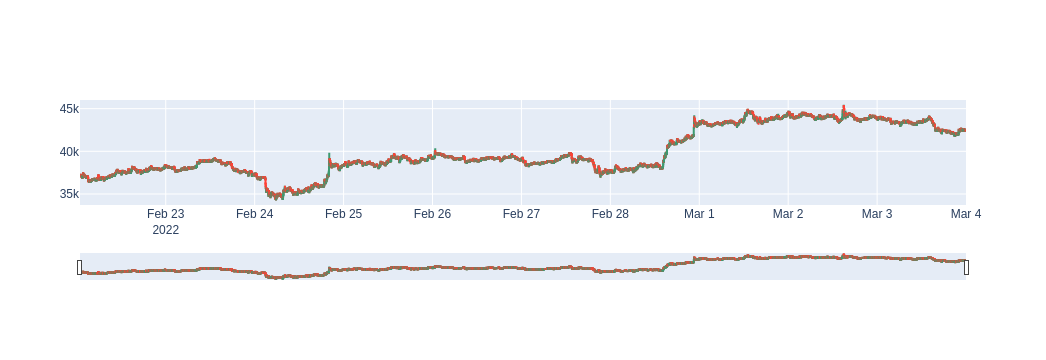

In [69]:
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

fig.show()

**Dynamic threshold fixed time horizon method (better: triple barrier method)**

In [91]:
# The time window for the features - N
feature_window = 60
# The time window for the labels (also called horizon) - M
label_window = 5

# Calculate daily returns on the adjusted close
df['daily_returns'] = df['Close'].pct_change()
# Calculate the threshold dynamically from the daily returns on a rolling basis on the feature_window
# The threshold is a function of the rolling standard deviation
df['return_threshold'] = 0.125 * \
    np.sqrt(feature_window)*df.daily_returns.rolling(feature_window).std()
# Calculate the future return from current price to the end of the label window
df['fut_returns'] = df['Close'].pct_change(
    +label_window).shift(-label_window)
# Assign class label to the feature window based on the returns of the label window compared to a dynamic threshold
df['target_class'] = np.where(df.fut_returns > df.return_threshold, 1, np.where(
    df.fut_returns < -df.return_threshold, -1, 0))

In [92]:
# Calculate daily returns on the adjusted close
df['daily_returns'] = df['Close'].pct_change()
# Calculate the threshold dynamically from the daily returns on a rolling basis on the feature_window
# The threshold is a function of the rolling standard deviation
df['return_threshold'] = 0.125 * \
    np.sqrt(feature_window)*df.daily_returns.rolling(feature_window).std()
# Calculate the future return from current price to the end of the label window
df['fut_returns'] = df['Close'].pct_change(
    +label_window).shift(-label_window)
# Assign class label to the feature window based on the returns of the label window compared to a dynamic threshold
df['target_class'] = np.where(df.fut_returns > df.return_threshold, 1, np.where(
    df.fut_returns < -df.return_threshold, -1, 0))

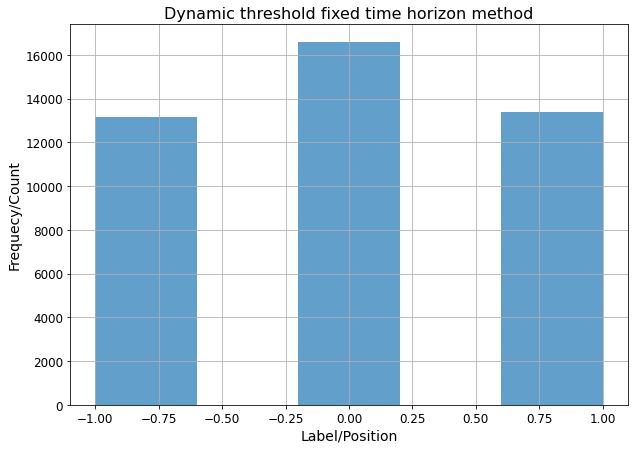

In [93]:
#path_prefix = '/media/john' # "/mnt/"
    path_prefix = "/mnt"

    #--------------------------------------------------------------------
    # Data Load
    #--------------------------------------------------------------------


    input_folder_db = os.path.join(path_prefix, 'Data/Tensor_Invest_Fund/data/Cryptos/')
    initial_date_load = datetime.today() - dateutil.relativedelta.relativedelta(days = 60)
    years_filter = [2022]

    dfs = []

    for symbol in SYMBOLS:
        for year in years_filter:

            file_name = os.path.join(input_folder_db, f'{symbol}', f'{year}_{symbol}.parquet'  )
            print("Reading file", file_name)
            
            df = pd.read_parquet(file_name)
            df = df[df['Date'] >= initial_date_load].copy()
            dfs.append(df)

            del df

    data = pd.concat(dfs, ignore_index = True).drop_duplicates()

    data.loc[:,'timestamp'] = data['Open Time'].copy()
    data.set_index('timestamp', inplace = True)
    data.sort_values(by = ['timestamp'], inplace = True)

    data = (data.groupby(['Ticker'], 
            group_keys= False)
            .apply(reindex_by_date)
            .reset_index())

    # Convert Unix timestamp to datetime 
    data.loc[:,'timestamp'] = pd.to_datetime(data['timestamp'], unit = "ms") 


    if True:    

        #--------------------------------------------------------------------
        # TBM Calculation
        #--------------------------------------------------------------------

        PTSL = [ [1,1], [2,2], [2,1] ] 

        # https://stackoverflow.com/questions/40115043/no-space-left-on-device-error-while-fitting-sklearn-model
        # Set tmp folder for joblib otherwise parallel label calculation runs into erro 
        # OSError: [Errno 28] No space left on device
        os.environ['JOBLIB_TEMP_FOLDER'] = os.path.join(input_folder_db, 'tmp')

        # Profit-Stop Loss ratio
        #ptsl = [1,1]
        v_barrier_minutes = 15
        delta_vertical_b = pd.Timedelta(minutes = v_barrier_minutes) # Vertical barrier length 
        output_folder_db = os.path.join(path_prefix, 'Data/Tensor_Invest_Fund/data/Cryptos/TBM')

        current_date = datetime.now().strftime("%Y-%m-%d-%H-%M")
        LOG_FILENAME = os.path.join( os.getcwd(), 'logs',  f"{current_date}_TBM_labels.log")
        logging.basicConfig(filename = LOG_FILENAME, level = logging.DEBUG, format= '%(asctime)s %(message)s', datefmt= '%m/%d/%Y %I:%M:%S %p')
        
        # Volatility Parameters
        delta_volatility = pd.Timedelta(hours=1)
        span_volatility = 100

        # Position Type 
        # 1: Long
        # -1: Short
        pt = 1
        n_jobs = -2
        max_nbytes = '0.8M'
        parallel_calculation = False

        for ptsl in PTSL:
            
            logging.info(f"Calculating labels for profit-stop ratio {ptsl}")
            

            if parallel_calculation:
                logging.info(f"using Parallel Computing {ptsl}")
            else:
                logging.info(f"using Linear Computing {ptsl}")

            print("Calculating labels for profit-stop ratio ", ptsl)

            for ticker in SYMBOLS:

                runtime_start = time.time()

                logging.info(f"Calculating labels for ticker {ticker}")

                #df_sub = data[(data['Date'] >'2022-03-25') & (data['Ticker'] == ticker)].copy()

                df_sub = data[(data['Ticker'] == ticker)].copy()

                print("Generating TBM Labels for ticker", ticker)
                print(" in the timeframe ", df_sub['Date'].min(), " - ", df_sub['Date'].max())
                print(df_sub.shape)

                df_sub = df_sub.set_index('timestamp').copy()

                try: 
                    TBM_parallel = TripleBarrierMethod(df_sub, 
                                        ticker,
                                        ptsl, 
                                        delta_vertical_b, 
                                        pt, 
                                        delta_volatility, 
                                        span_volatility, 
                                        n_jobs,
                                        parallel_calculation, 
                                        max_nbytes)

                    TBM_parallel.run()

                    print("\n")
                    print(TBM_parallel.data['label'].value_counts())
                    print("\n")

                    TBM_parallel.store_data(output_folder_db, v_barrier_minutes)
                except Exception as e:
                    logging.info(e)


                runtime = round((time.time() - runtime_start)/60, 2)
                logging.info(f" Runtime was {runtime} minutes")


In [94]:
df.target_class.value_counts()

 0    16566
 1    13404
-1    13178
Name: target_class, dtype: int64

In [95]:
predictors_list = [
    'ret3', 'ret5', 'ret10', 'ret20', 'std3', 'std5', 'std10', 'std20', 'ADX',
    'RSI', 'SMA', 'corr', 'volatility', 'volatility2'
]

X = df[predictors_list]
y = df.target_class

In [96]:
# Split the data into train and test dataset
split_percentage = 0.8

split = int(split_percentage*len(X))

X_train = X[:split]
X_test = X[split:]

y_train = y[:split]
y_test = y[split:]

# Create classification tree model
clf = XGBClassifier(eval_metric='logloss', n_jobs=-1, random_state=42)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

## Model Evaluation

In [97]:
# Test accuracy
accuracy_test = accuracy_score(y_test, y_pred)
print("accuracy score:", round(accuracy_test, 4))

if accuracy_test > float(0.55):
    print("Saved updated model!")
    pickle.dump(clf, open("xgb_clf.pkl", "wb"))

accuracy score: 0.3817


In [98]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

          -1       0.33      0.24      0.28      2598
           0       0.41      0.62      0.49      3350
           1       0.35      0.22      0.27      2682

    accuracy                           0.38      8630
   macro avg       0.37      0.36      0.35      8630
weighted avg       0.37      0.38      0.36      8630



## Backtesting 

In [99]:
# Vectorized Backtesting
backtest_df = df[split:].copy()
backtest_df["pred"] = y_pred
backtest_df["strategy"] = backtest_df.pred * backtest_df.Return

In [100]:
backtest_df["creturns"] = backtest_df["Return"].cumsum().apply(np.exp)
backtest_df["cstrategy"] = backtest_df["strategy"].cumsum().apply(np.exp)

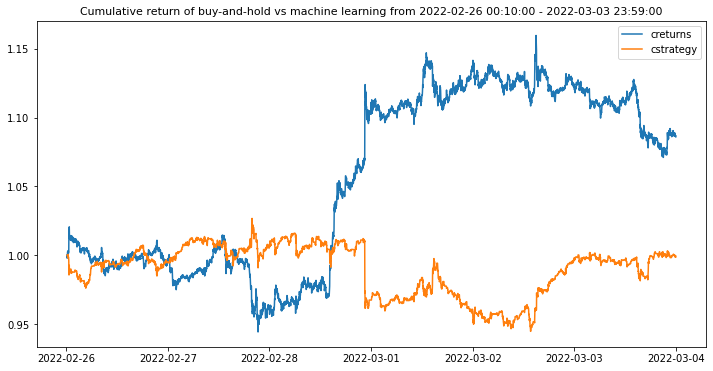

In [101]:
plt.figure(figsize=(12, 6))
plt.plot(backtest_df.index, backtest_df["creturns"])
plt.plot(backtest_df.index, backtest_df["cstrategy"])
plt.legend(["creturns", "cstrategy"])
plt.title(f"Cumulative return of buy-and-hold vs machine learning from {backtest_df.index[0]} - {backtest_df.index[-1]}", fontsize=11)
plt.show()

In [102]:
backtest_df["trades"] = backtest_df.pred.diff().fillna(0).abs()

In [103]:
backtest_df.trades.value_counts()

0.0    5730
1.0    2460
2.0     440
Name: trades, dtype: int64

## Strategy Analytics

In [33]:
analytics_df = df.copy()
X = analytics_df[predictors_list]
y = analytics_df.target_class

In [34]:
xgb_classifier = XGBClassifier(n_jobs=-1, eval_metric='logloss', random_state=42)
xgb_classifier = xgb_classifier.fit(X, y)

In [35]:
y_pred = xgb_classifier.predict(X)

In [36]:
analytics_df["predicted_signal"] = y_pred

In [37]:
analytics_df = analytics_df[["Close", "predicted_signal"]]

In [38]:
analytics_df["predicted_signal"].value_counts()

-1    537
 1    449
 0    445
Name: predicted_signal, dtype: int64

In [39]:
analytics_df.head()

,Close,predicted_signal
Date,,
2022-03-03 00:09:00,43759.18,0
2022-03-03 00:10:00,43735.66,0
2022-03-03 00:11:00,43699.99,0
2022-03-03 00:12:00,43724.99,0
2022-03-03 00:13:00,43714.76,0


In [40]:
from strategy_analytics import *

In [41]:
trades = get_trades(analytics_df, 'Close', 'predicted_signal')
print('Trade Details')
trades.head()

Trade Details


,Position,Entry Time,Entry Price,Exit Time,Exit Price,PnL
0,-1,2022-03-03 01:09:00,43938.92,2022-03-03 01:10:00,43850.00,88.92
1,1,2022-03-03 01:13:00,43773.50,2022-03-03 01:28:00,43878.13,104.63
2,-1,2022-03-03 01:29:00,43880.74,2022-03-03 01:39:00,43770.20,110.54
3,-1,2022-03-03 01:40:00,43816.31,2022-03-03 01:44:00,43788.38,27.93
4,1,2022-03-03 01:46:00,43754.99,2022-03-03 01:50:00,43776.79,21.80


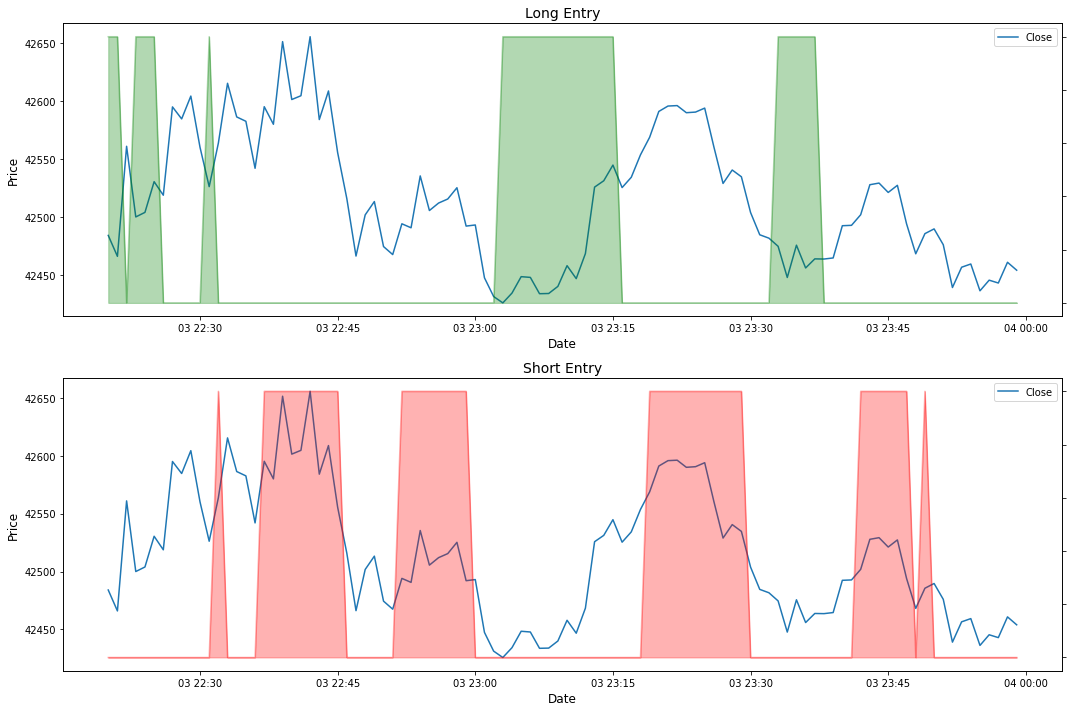

In [42]:
# Showing the last 100 points for illustration purpose
data_for_plot = analytics_df[-100:]
data_for_plot['long_entry'] = data_for_plot.predicted_signal == 1
data_for_plot['short_entry'] = data_for_plot.predicted_signal == -1

fig = plt.figure(figsize=(15, 10))

# Sub plot for the long position
ax = fig.add_subplot(211)

# Plot the close price
ax.plot(data_for_plot['Close'], label='Close')

# Set the title and axis labels
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price', fontsize=12)
ax.set_title('Long Entry', fontsize=14)
ax.legend()

# Plot the time where the long position is held
ax2 = ax.twinx()
ax2.plot(data_for_plot['long_entry'], color='g', alpha=0.3)
ax2.fill_between(data_for_plot['long_entry'].index,
                 data_for_plot['long_entry'].values, color='g', alpha=0.3)
ax2.tick_params(labelright=False)

# Sub plot for the short position
ax = fig.add_subplot(212)

# Plot the close price
ax.plot(data_for_plot['Close'], label='Close')


# Set the title and axis labels
ax.set_title('Short Entry', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price', fontsize=12)
ax.legend()

# Plot the time where the short position is held
ax2 = ax.twinx()
ax2.plot(data_for_plot['short_entry'], color='r', alpha=0.3)
ax2.fill_between(data_for_plot['short_entry'].index,
                 data_for_plot['short_entry'].values, color='r', alpha=0.3)
ax2.tick_params(labelright=False)

plt.tight_layout()
plt.show()

In [43]:
analytics = get_analytics(trades)
print('Strategy Analytics')
round(analytics,2)

Strategy Analytics


,Strategy
num_of_long,85.00
num_of_short,100.00
total_trades,185.00
gross_profit,11602.37
gross_loss,-730.98
net_profit,10871.39
winners,150.00
losers,35.00
win_percentage,81.08
loss_percentage,18.92


Start date,2022-03-03
End date,2022-03-03
Total months,68
,Backtest
Annual return,4.5%
Cumulative returns,28.6%
Annual volatility,1.2%
Sharpe ratio,3.82
Calmar ratio,8.49
Stability,0.99
Max drawdown,-0.5%


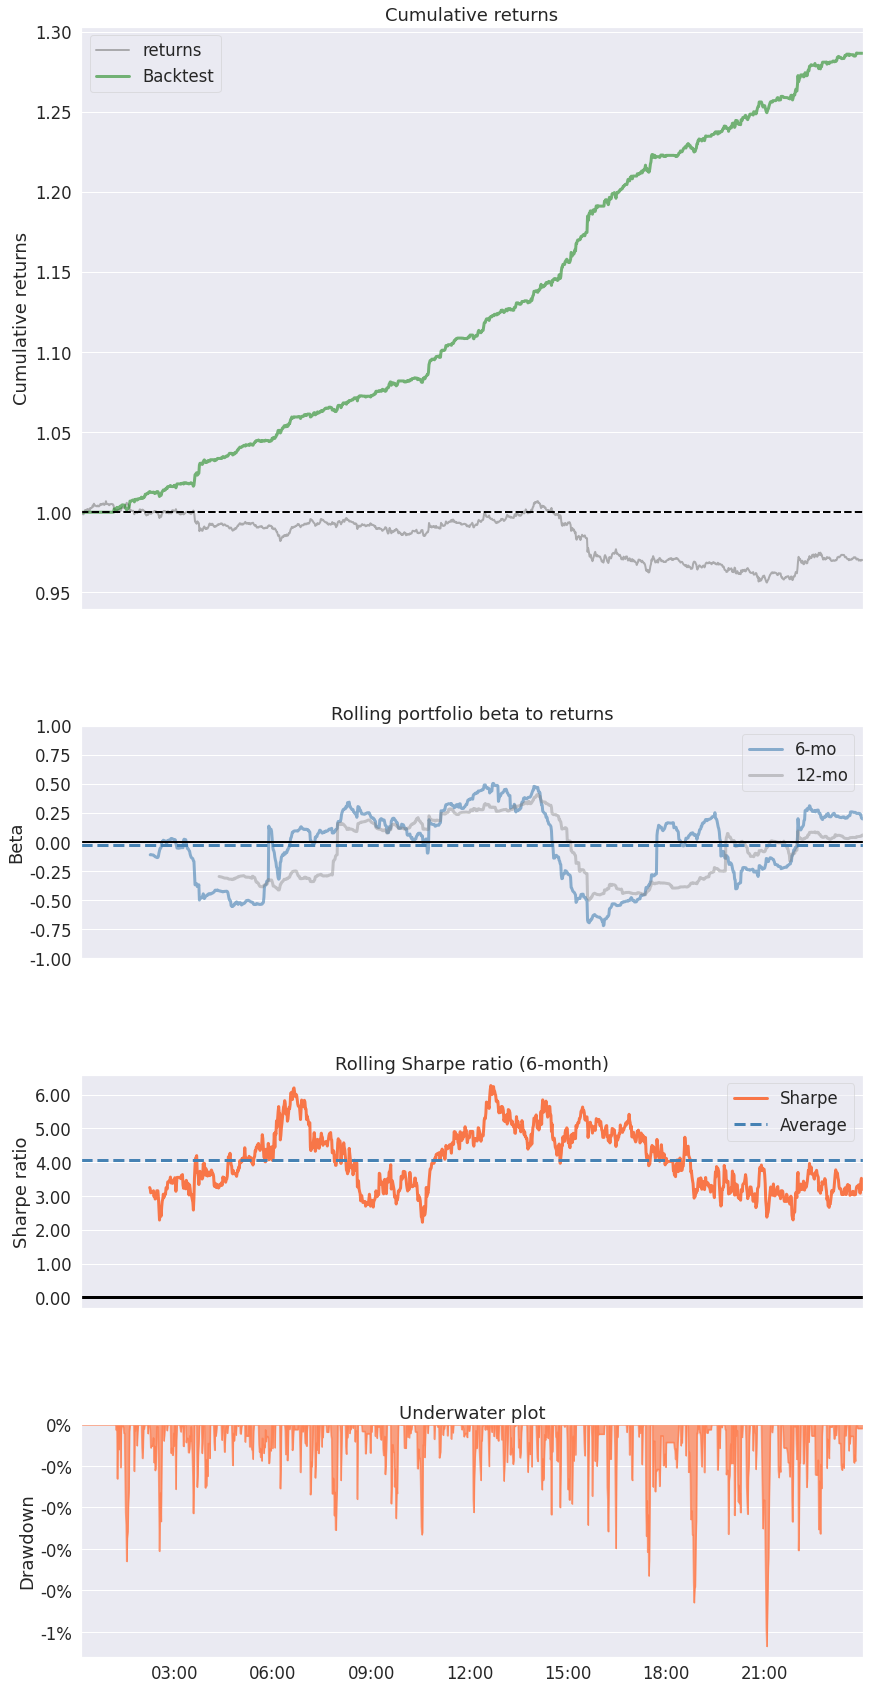

In [44]:
# pyfolio
analytics_df['returns'] = analytics_df.Close.pct_change()
analytics_df['strategy_returns'] = analytics_df['returns'] * analytics_df['predicted_signal'].shift(1)
analytics_df = analytics_df.dropna()
pf.create_simple_tear_sheet(analytics_df['strategy_returns'],benchmark_rets=analytics_df['returns'])

## Simulation

In [74]:
simulation_df = df.copy()

In [73]:
# This function takes the raw data as its input.
def create_features(data):

    data = data.copy()
    # We make a set containing the column names of the initial raw data
    # We will be dropping these initial columns later
    # to create a dataframe with only the necessary predictor columns.
    initial_columns = set(data.columns)

    # Returns
    data['ret1'] = data.Close.pct_change()
    data['ret3'] = data.ret1.rolling(3).sum()
    data['ret5'] = data.ret1.rolling(5).sum()
    data['ret10'] = data.ret1.rolling(10).sum()
    data['ret20'] = data.ret1.rolling(20).sum()

    # Standard Deviation
    data['std3'] = data.ret1.rolling(3).std()
    data['std5'] = data.ret1.rolling(5).std()
    data['std10'] = data.ret1.rolling(10).std()
    data['std20'] = data.ret1.rolling(20).std()
    
    # Technical Indicators (Talib)
    data['ADX'] = ta.ADX(data['High'].values, data['Low'].values,
                    data['Close'].values, timeperiod=14)
    data['RSI'] = ta.RSI(data['Close'].values, timeperiod=14)
    data['SMA'] = ta.SMA(data['Close'].values, timeperiod=20)

    # Drop the null values. Remember that this action will remove some initial rows in the dataset
    data = data.dropna()

    # Future returns
    data['retFut1'] = data.ret1.shift(-1)

    # Select only the columns which will be used as features and ignore the raw data
    all_columns = set(data.columns)
    predictor_list = list(all_columns-initial_columns)

    # Drop the future returns from the input as this will used in creating the target dataset
    predictor_list.remove('retFut1')

    # Define predictor variables (X) and a target variable (y)
    X = data[predictor_list]
    y = np.where(data.retFut1 > 0, 1, -1)
    y = pd.Series(y)

    return X, y

In [75]:
X, y = create_features(simulation_df)

In [76]:
simulation_length = 252

In [77]:
# Here we add one to represent the one data point that would have all the features after dropping the null values
minimum_feature_length = len(df)-len(X)+1

In [78]:
performance_length = 20

In [80]:
data_sim = simulation_df[-(minimum_feature_length +
                        performance_length+simulation_length):].copy()

# Assign the remaining data to train dataset
data_train = simulation_df[:-(minimum_feature_length +
                           performance_length+simulation_length)].copy()

# Create the features and target datasets for the train data. We will use these to create our initial model,
# which we would be using to begin the simulation with.
X, y = create_features(simulation_df)

In [81]:
def train_model(X, y):
    # Instantiate the Machine Learning model
    
    #model = RandomForestClassifier(n_estimators=200, class_weight='balanced')
    model = XGBClassifier(
                            n_estimators=200, 
                            class_weight='balanced', 
                            #eval_metric = "logloss", 
                            #use_label_encoder=False,
                            verbosity=0, 
                            n_jobs=-1)
    
    # Fit the data to the model to train it
    model.fit(X, y)
    # Return the model as output
    return model


model = train_model(X, y)

In [82]:
def save_model(model_name, model_saved_name):
    # Open a file with the mentioned name on the local machine
    with open(model_saved_name, 'wb') as model_save:
        # Use the dump command to save it
        pickle.dump(model_name, model_save)


model_saved_name = 'model_save.pkl'
save_model(model, model_saved_name)

In [83]:
def load_model(model_saved_name):
    # Open the file containing the model with the mentioned name on the local machine
    with open(model_saved_name, 'rb') as file:
        # Load the model and assign it to a variable
        model = pickle.load(file)
        # Return the model
        return model

In [84]:
def create_new_model(data, model_saved_name):
    # Create feature from the raw data
    X, y = create_features(data)
    # Train the model on the features generated
    model = train_model(X, y)
    # Save the model on the local machine
    save_model(model, model_saved_name)

In [94]:
# Create a list to save the performance during the simulation
strategy_perf=[]
for i in range(simulation_length):
    # Load enough past data points to check the performance and to create features for the these past data points.
    # The features of the last data point in the dataset past_data 
    # will be used to make a prediction if the past performance of the model is good.
    past_data=data_sim[i:i+minimum_feature_length+performance_length]
    # Create the features and targets over the past_data 
    X,y = create_features(past_data)
    # Load model from the local machine
    model=load_model(model_saved_name)
    # Predict using the loaded model 
    predictions= model.predict(X)
    # Check of the model's performance over the performance_length
    accuracy= accuracy_score(y.iloc[:-1],predictions[:-1])
    # If the performance is satisfactory then use the prediction on the last data point 
    if accuracy>0.55:
        print("\nStrategy's past performance is good") 
        print("\nToday's trading signal is: {}".format("Buy" if predictions[-1]>0  else "Sell"))
        # Add the prediction of the model to the list strategy_perf, we will use this to check the strategy's performance
        strategy_perf.append(predictions[-1])
    else:
        print("\nRetraining the model")
        print("\nNot trading for today")        
        # Since we wont be training at this data point, we will adding 0 to the list strategy_perf
        strategy_perf.append(0)
        # Create a copy of the new train data by rolling forward the train data set by the iteration value
        # As we move forward in the simulation the old data that doesn't over lap with the current simulation data
        # can be added to the train data
        data=data_train[i:-(minimum_feature_length+performance_length+simulation_length)+i].copy()
        # Re-train the model and create a new model using the 'data'
        create_new_model(data,model_saved_name)


Strategy's past performance is good

Today's trading signal is: Sell

Strategy's past performance is good

Today's trading signal is: Sell

Strategy's past performance is good

Today's trading signal is: Sell

Strategy's past performance is good

Today's trading signal is: Sell

Strategy's past performance is good

Today's trading signal is: Buy

Strategy's past performance is good

Today's trading signal is: Sell

Strategy's past performance is good

Today's trading signal is: Sell

Strategy's past performance is good

Today's trading signal is: Buy

Strategy's past performance is good

Today's trading signal is: Sell

Strategy's past performance is good

Today's trading signal is: Sell

Strategy's past performance is good

Today's trading signal is: Buy

Strategy's past performance is good

Today's trading signal is: Buy

Strategy's past performance is good

Today's trading signal is: Buy

Strategy's past performance is good

Today's trading signal is: Sell

Strategy's past performa

In [95]:
# Let's check the trading signals generated during the simulation
strategy_perf

[-1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1

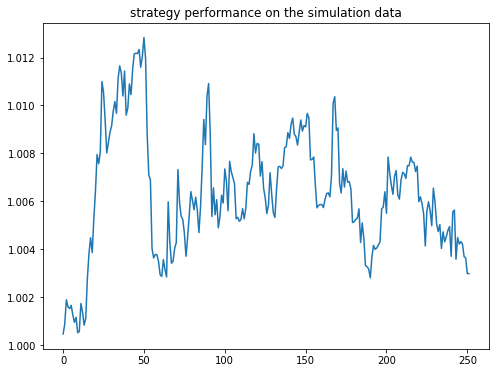

In [96]:
# Multiply the future percentage returns with the signals generated to calculate the strategy's performance
strategy_perf1=pd.Series(strategy_perf*data_sim.Close.pct_change().shift(-1).iloc[-simulation_length:].values)
plt.figure(figsize=(8, 6))
plt.plot(np.nancumprod(strategy_perf1+1))
plt.title("strategy performance on the simulation data")
plt.show()

## ML Live Trading 

In [113]:
class MLTrader():
    
    def __init__(self, symbol, bar_length, model, units, position = 0):
        
        self.symbol = symbol
        self.bar_length = bar_length
        self.available_intervals = ["1m", "3m", "5m", "15m", "30m", "1h", "2h", "4h", "6h", "8h", "12h", "1d", "3d", "1w", "1M"]
        self.units = units
        self.position = position
        self.trades = 0 
        self.trade_values = []
        
        #*****************add strategy-specific attributes here******************
        self.model = model
        #************************************************************************
    
    def start_trading(self, historical_days):
        
        self.twm = ThreadedWebsocketManager()
        self.twm.start()
        
        if self.bar_length in self.available_intervals:
            self.get_most_recent(symbol = self.symbol, interval = self.bar_length,
                                 days = historical_days)
            self.twm.start_kline_socket(callback = self.stream_candles,
                                        symbol = self.symbol, interval = self.bar_length)
        # "else" to be added later in the course 
    
    def get_most_recent(self, symbol, interval, days):
    
        now = datetime.utcnow()
        past = str(now - timedelta(days = days))
    
        bars = client.get_historical_klines(symbol = symbol, interval = interval,
                                            start_str = past, end_str = None, limit = 1000)
        df = pd.DataFrame(bars)
        df["Date"] = pd.to_datetime(df.iloc[:,0], unit = "ms")
        df.columns = ["Open Time", "Open", "High", "Low", "Close", "Volume",
                      "Clos Time", "Quote Asset Volume", "Number of Trades",
                      "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore", "Date"]
        df = df[["Date", "Open", "High", "Low", "Close", "Volume"]].copy()
        df.set_index("Date", inplace = True)
        for column in df.columns:
            df[column] = pd.to_numeric(df[column], errors = "coerce")
        df["Complete"] = [True for row in range(len(df)-1)] + [False]
        
        self.data = df
    
    def stream_candles(self, msg):
        
        # extract the required items from msg
        event_time = pd.to_datetime(msg["E"], unit = "ms")
        start_time = pd.to_datetime(msg["k"]["t"], unit = "ms")
        first   = float(msg["k"]["o"])
        high    = float(msg["k"]["h"])
        low     = float(msg["k"]["l"])
        close   = float(msg["k"]["c"])
        volume  = float(msg["k"]["v"])
        complete=       msg["k"]["x"]
        
        # stop trading session
        if self.trades >= 5: # stop stream after 5 trades
            self.twm.stop()
            if self.position == 1:
                order = client.create_order(symbol = self.symbol, side = "SELL", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING NEUTRAL AND STOP")
                self.position = 1
            elif self.position == -1:
                order = client.create_order(symbol = self.symbol, side = "BUY", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING NEUTRAL AND STOP")
                self.position = -1
            else: 
                print("STOP")
    
        # print out
        print(".", end = "", flush = True) # just print something to get a feedback (everything OK) 
    
        # feed df (add new bar / update latest bar)
        self.data.loc[start_time] = [first, high, low, close, volume, complete]
        
        # prepare features and define strategy/trading positions whenever the latest bar is complete
        if complete == True:
            self.define_strategy()
            self.execute_trades()
        
    def define_strategy(self): # "strategy-specific"
        
        df = self.data.copy()
        
        #******************** define your strategy here ************************
        # Features
        df['ADX'] = ta.ADX(df['High'].values, df['Low'].values, df['Close'].values, timeperiod=5)
        df['RSI'] = ta.RSI(df['Close'].values, timeperiod=5)
        df['SMA'] = ta.SMA(df['Close'].values, timeperiod=10)
        
        predictors_list = ['ADX', 'RSI', 'SMA']

        df["position"] = xgb.predict(df[predictors_list])
        #***********************************************************************
        
        self.prepared_data = df.copy()
    
    def execute_trades(self): # NEW!
        if self.prepared_data["position"].iloc[-1] == 1: # if position is long -> go/stay long
            if self.position == -1:
                order = client.create_order(symbol = self.symbol, side = "BUY", type = "MARKET", quantity = self.units)
                print("GOING LONG")
            self.position = 1
        elif self.prepared_data["position"].iloc[-1] == -1: # if position is neutral -> go/stay neutral
            if self.position == 1:
                order = client.create_order(symbol = self.symbol, side = "SELL", type = "MARKET", quantity = self.units)
                print("GOING NEUTRAL")
            self.position = -1

In [137]:
%run ./Binance_Keys.ipynb
client = Client(api_key = api_key, api_secret = secret_key, tld = "com", testnet = True)
if client.get_account()["balances"][0]["free"] > str(100):
    # activate websocket manager
    twm = ThreadedWebsocketManager()
    print("Ready to trade on binance testnet!")
    print("="*28)
    print(binance_account_info())

Binance Testnet account keys...
Ready to trade on binance testnet!
  asset         free  locked
0   BNB    1000.0000     0.0
1   BTC       1.0100     0.0
2  BUSD   10000.0000     0.0
3   ETH     100.0000     0.0
4   LTC     500.0000     0.0
5   TRX  500000.0000     0.0
6  USDT    9560.1334     0.0
7   XRP   50000.0000     0.0


In [115]:
symbol = "BTCUSDT"
bar_length = "1m"
units = 0.01
position = 0

xgb = pickle.load(open("xgb_clf.pkl", "rb"))

In [116]:
trader = MLTrader(symbol = symbol, bar_length = bar_length, model = xgb, units = units, position = position)

In [117]:
trader.start_trading(historical_days = 3)

........................................................................GOING NEUTRAL
..........................................................GOING LONG
............................................................................................................................................................................................................

In [118]:
trader.twm.stop()

.

In [119]:
results_df = trader.prepared_data
results_df.tail()

,Open,High,Low,Close,Volume,Complete,ADX,RSI,SMA,position
Date,,,,,,,,,,
2022-03-02 10:42:00,44189.18,44218.41,44187.43,44218.39,19.44488,True,78.065810,48.484816,44241.796,1
2022-03-02 10:43:00,44218.40,44218.40,44169.55,44180.26,12.96342,True,78.868269,37.224887,44239.041,1
2022-03-02 10:44:00,44180.25,44205.57,44180.25,44200.38,11.92493,True,79.510236,45.563458,44233.636,1
2022-03-02 10:45:00,44200.39,44212.79,44161.70,44189.33,27.68056,True,79.824408,41.755741,44230.851,1
2022-03-02 10:46:00,44189.34,44229.05,44184.90,44219.11,16.18148,True,80.098311,54.550900,44224.048,1


<AxesSubplot:xlabel='Date'>

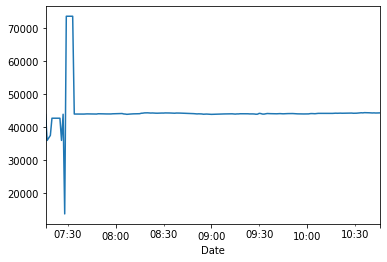

In [129]:
results_df.Close.plot()

<AxesSubplot:xlabel='Date'>

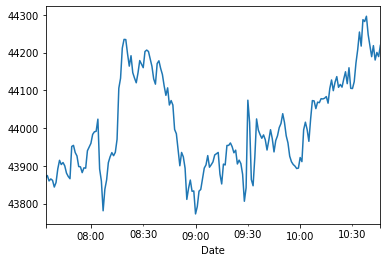

In [132]:
results_df[18:].Close.plot()

In [133]:
binance_account_info()

,asset,free,locked
0,BNB,1000.0000,0.0
1,BTC,1.0100,0.0
2,BUSD,10000.0000,0.0
3,ETH,100.0000,0.0
4,LTC,500.0000,0.0
5,TRX,500000.0000,0.0
6,USDT,9560.1334,0.0
7,XRP,50000.0000,0.0


## EDA: Trading Time Frame

In [122]:
eda_df = get_history(symbol = "BTCUSDT", interval = "1h", start = '2022-01-01', end = now_value)

In [124]:
eda_df.shape

(1431, 10)

In [127]:
eda_df.index = eda_df.index.tz_localize('UTC')

In [128]:
eda_df["NYTime"] = eda_df.index.tz_convert("America/New_York")

In [129]:
eda_df["hour"] = eda_df.NYTime.dt.hour

In [130]:
eda_df["price_change_abs"] = eda_df["Close"].diff().abs()

In [131]:
eda_df.dropna(inplace = True)

In [133]:
by_hour = eda_df.groupby("hour")[["Volume", "price_change_abs"]].mean()

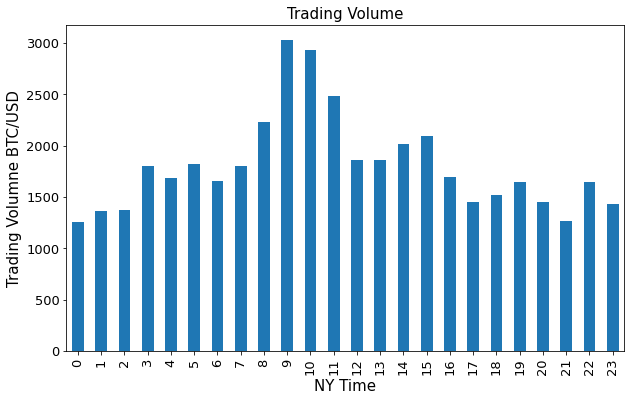

In [134]:
by_hour.Volume.plot(kind = "bar", figsize = (10, 6), fontsize = 13)
plt.xlabel("NY Time", fontsize = 15)
plt.ylabel("Trading Volumne BTC/USD", fontsize = 15)
plt.title("Trading Volume", fontsize = 15)
plt.show()

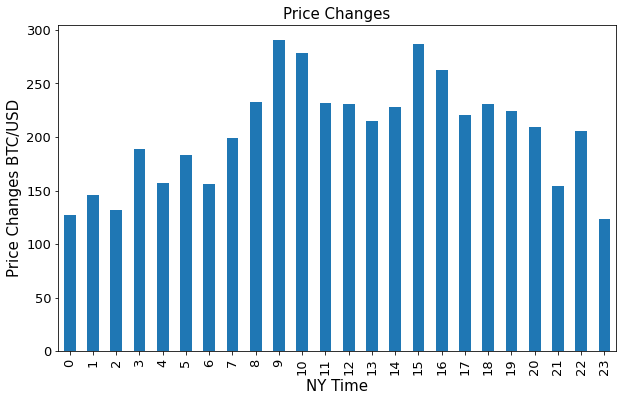

In [135]:
by_hour.price_change_abs.plot(kind = "bar", figsize = (10, 6), fontsize = 13)
plt.xlabel("NY Time", fontsize = 15)
plt.ylabel("Price Changes BTC/USD", fontsize = 15)
plt.title("Price Changes", fontsize = 15)
plt.show()